In [1]:
import datetime
import json
import ollama

# 这个系统提示是关键，它告诉 LLM 它可以调用哪些函数以及它们的 JSON 描述
TOOL_SCHEMA = [
    {
        "type": "function",
        "function": {
            "name": "get_stock_zh_a_spot_data",
            "description": "获取 A 股的历史行情数据，并将数据存入 SQLite 数据库的固定表中。返回包含最新价格的摘要。",
            "parameters": {
                "type": "object",
                "properties": {
                    "symbol": {"type": "string", "description": "股票代码或指数代码，如 '600519' 或 'sh000001'"},
                    "period": {"type": "string", "description": "数据周期 ('daily', 'weekly', 'monthly')"},
                    "start_date": {"type": "string", "description": "开始日期，格式 'YYYYMMDD'"},
                    "end_date": {"type": "string", "description": "结束日期，格式 'YYYYMMDD'"}
                },
                "required": ["symbol"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "visualize_stock_data_trend",
            "description": "从数据库中读取固定表中的数据，计算滑动平均线，生成并显示价格趋势图。用于响应'画图'、'走势图'等请求。注意：此工具需在'get_stock_zh_a_spot_data'调用后使用。",
            "parameters": {
                "type": "object",
                "properties": {
                    "symbol": {"type": "string", "description": "股票代码，仅用于图表标题。"}
                },
                "required": ["symbol"]
            }
        }
    }
]

tool_schema_str = json.dumps(TOOL_SCHEMA, indent=2)

SYSTEM_PROMPT_TEMPLATE = """
你是一个专业的金融数据分析助手。你的主要目标是帮助用户获取、处理和可视化股票和指数数据。

---
核心指令：
1. **任务与工具匹配：** 如果用户的请求涉及到获取市场数据（如价格、历史数据、趋势、走势图），你**必须**使用提供的工具。
2. **工具调用：** 如果你决定调用工具，请直接按照 Ollama/GPT-OSS 规范返回结构化的 `tool_calls` 字段。
3. **最终回复：** 在工具调用完成后，基于工具返回的结果进行专业的分析和回复。
4. **简洁性：** 除非必要，避免冗长或不相关的讨论。

你拥有以下工具（JSON Schema）：

{}

---
"""

SYSTEM_PROMPT = SYSTEM_PROMPT_TEMPLATE.format(tool_schema_str)

MODEL_NAME = 'gpt-oss:20b'
context_messages = [{'role': 'system', 'content': SYSTEM_PROMPT}]
user_input="现在的上证指数是多少"
context_messages.append({'role': 'user', 'content': user_input})
chatResponse = ollama.chat(
        model=MODEL_NAME,
        messages=context_messages,
        stream=False,
    )
chatResponse


ChatResponse(model='gpt-oss:20b', created_at='2025-11-14T10:00:49.1691746Z', done=True, done_reason='stop', total_duration=12148102500, load_duration=10340038100, prompt_eval_count=1025, prompt_eval_duration=476206700, eval_count=127, eval_duration=1243200500, message=Message(role='assistant', content='', thinking='The user asks: "现在的上证指数是多少" – they want current Shanghai Composite Index value. According to instruction, must use the tool get_stock_zh_a_spot_data with symbol "sh000001" maybe. They want current price. So call tool get_stock_zh_a_spot_data with symbol sh000001, period maybe daily, no start_date, end_date? The function returns latest spot data. We should call it.', images=None, tool_name=None, tool_calls=[ToolCall(function=Function(name='get_stock_zh_a_spot_data', arguments={'period': 'daily', 'symbol': 'sh000001'}))]))

In [12]:
from agent_app import *
import os
os.environ['NO_PROXY'] = '*'
os.environ['no_proxy'] = '*'

chatResponse.message.tool_calls

[ToolCall(function=Function(name='get_stock_zh_a_spot_data', arguments={'period': 'daily', 'symbol': 'sh000001'}))]

In [13]:
execute_tool_call(chatResponse.message.tool_calls)

'{"error": "AkShare/DB \\u8c03\\u7528\\u5931\\u8d25: (\'Connection aborted.\', RemoteDisconnected(\'Remote end closed connection without response\'))"}'

In [4]:
import os
import json
import datetime
import sys
# 假设 akshare_tools.py 包含了 Tushare 初始化和两个函数
try:
    from akshare_tools import get_stock_zh_a_spot_data, visualize_stock_data_trend
except ImportError:
    print("❌ 错误: 无法导入 akshare_tools.py 中的函数。请确保文件存在且位于正确的路径。")
    sys.exit(1)


def run_tushare_test():

    # ----------------------------------------------
    # 步骤 1: 环境检查
    # ----------------------------------------------
    token = "2dda5d9690d6bb9f6169b44ad1090fd5e0e22a2e9d0d9adbd47e21ba"
    if not token:
        print("="*60)
        print("🚨 TUSHARE_TOKEN 警告：")
        print("TUSHARE_TOKEN 环境变量未设置！数据获取将失败。")
        print("请在运行前设置该变量。例如 (PowerShell): $env:TUSHARE_TOKEN = 'YOUR_TOKEN'")
        print("="*60)
        # 不退出，让代码继续，但工具函数内部会返回错误

    print(f"当前 Tushare Token 状态: {'已设置' if token else '未设置/将失败'}")
    print("-" * 60)

    # ----------------------------------------------
    # 步骤 2: 定义测试参数
    # ----------------------------------------------
    TEST_SYMBOL = "600519"  # 贵州茅台

    # 基于当前日期动态生成日期范围 (最近180天)
    end_date_obj = datetime.date.today()
    start_date_obj = end_date_obj - datetime.timedelta(days=180)

    # 转换为 Tushare/SQLite 需要的 YYYYMMDD 格式
    END_DATE = end_date_obj.strftime("%Y%m%d")
    START_DATE = start_date_obj.strftime("%Y%m%d")

    print(f"测试股票: {TEST_SYMBOL}")
    print(f"日期范围: {START_DATE} 至 {END_DATE}")
    print("-" * 60)

    # ----------------------------------------------
    # 步骤 3: 测试数据获取 (get_stock_zh_a_spot_data)
    # ----------------------------------------------
    print("🤖 1. 正在调用 get_stock_zh_a_spot_data (数据获取)...")

    # 函数返回 JSON 字符串
    data_result_json = get_stock_zh_a_spot_data(
        symbol=TEST_SYMBOL,
        start_date=START_DATE,
        end_date=END_DATE
    )

    data_result = json.loads(data_result_json)

    if "error" in data_result:
        print(f"\n❌ 数据获取失败！请检查日志。")
        print(f"   错误信息: {data_result['error']}")
        return

    print("\n✅ 数据获取成功！")
    print("   摘要信息:")
    print(json.dumps(data_result, indent=4, ensure_ascii=False))
    print("-" * 60)

    # ----------------------------------------------
    # 步骤 4: 测试可视化 (visualize_stock_data_trend)
    # ----------------------------------------------
    print("🤖 2. 正在调用 visualize_stock_data_trend (可视化)...")

    # 函数返回 JSON 字符串 (并显示图表)
    viz_result_json = visualize_stock_data_trend(symbol=TEST_SYMBOL)

    viz_result = json.loads(viz_result_json)

    if "error" in viz_result:
        print(f"\n❌ 可视化失败！")
        print(f"   错误信息: {viz_result['error']}")
        return

    print(f"\n✅ 可视化成功！结果: {viz_result['message']}")
    print("-" * 60)

# 运行测试
run_tushare_test()

Tushare 或数据库操作失败: 抱歉，您没有接口访问权限，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。


当前 Tushare Token 状态: 已设置
------------------------------------------------------------
测试股票: 600519
日期范围: 20250518 至 20251114
------------------------------------------------------------
🤖 1. 正在调用 get_stock_zh_a_spot_data (数据获取)...

❌ 数据获取失败！请检查日志。
   错误信息: Tushare/DB 调用失败: 抱歉，您没有接口访问权限，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。


生成或显示图表时发生错误: '5日均线'


'{"error": "\\u751f\\u6210\\u53ef\\u89c6\\u5316\\u56fe\\u8868\\u5931\\u8d25: \'5\\u65e5\\u5747\\u7ebf\'\\u3002"}'

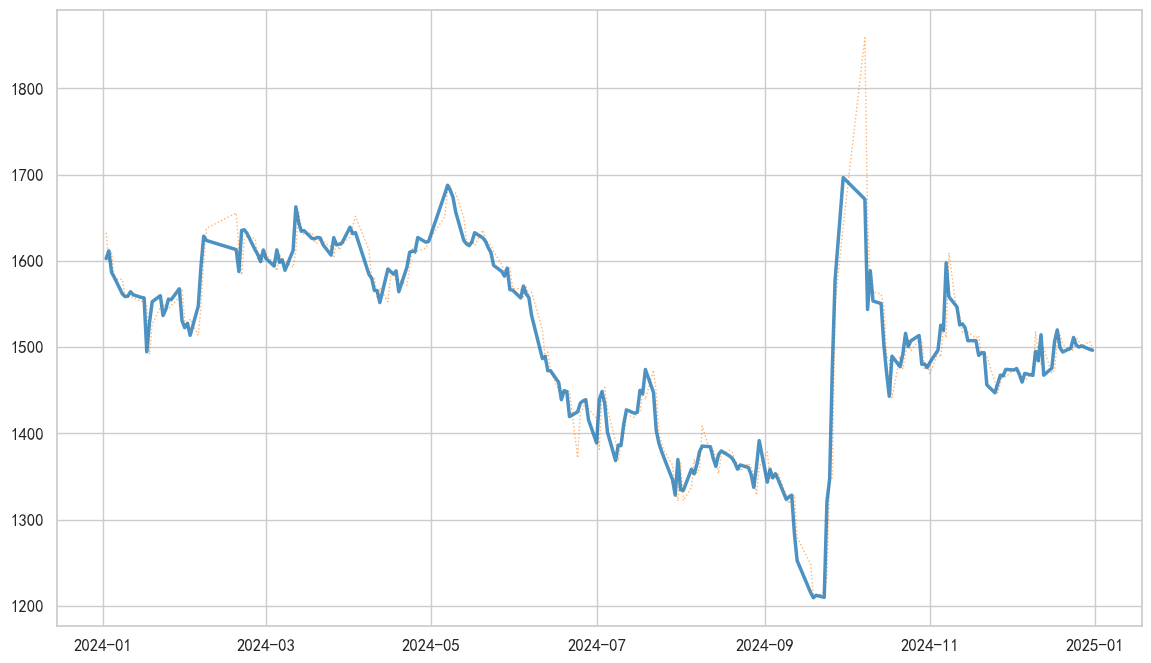

In [6]:
visualize_stock_data_trend("600519")

In [9]:
import akshare as ak
ak.macro_china_gdp_yearly()

,商品,日期,今值,预测值,前值
0,中国GDP年率报告,2011-01-20,9.8,9.5,9.6
1,中国GDP年率报告,2011-04-15,9.7,9.4,9.8
2,中国GDP年率报告,2011-07-13,9.5,9.5,9.7
3,中国GDP年率报告,2011-10-18,9.1,9.2,9.5
4,中国GDP年率报告,2012-01-17,8.9,8.8,9.1
...,...,...,...,...,...
56,中国GDP年率报告,2024-07-15,4.7,5.1,5.3
57,中国GDP年率报告,2024-10-18,4.6,4.6,4.7
58,中国GDP年率报告,2025-01-17,5.4,5.0,4.6
59,中国GDP年率报告,2025-04-16,5.4,5.2,5.4
